In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "1000SHIBUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2021-07-01"
        self.end_date = "2022-04-18"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = False  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
linear perpetual
2022-04-18T15:38:43  Validating file 35488350_35499999_1625097601572_1625103068223.csv 2021-07-01T07:00:01.572000 


C:\AgodaGit\passivbot\downloader.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gaps = gaps.append(


2022-04-18T15:38:44  Filling gaps from id 35400000 to id 35488349 
2022-04-18T15:38:44  fetched ticks 1000SHIBUSDT 35400000 2021-07-01T00:11:38.893000 
2022-04-18T15:38:45  fetched ticks 1000SHIBUSDT 35400999 2021-07-01T00:15:15.173000 
2022-04-18T15:38:46  fetched ticks 1000SHIBUSDT 35401998 2021-07-01T00:20:27.868000 
2022-04-18T15:38:46  fetched ticks 1000SHIBUSDT 35402997 2021-07-01T00:26:18.341000 
2022-04-18T15:38:47  fetched ticks 1000SHIBUSDT 35403996 2021-07-01T00:32:08.557000 
2022-04-18T15:38:48  fetched ticks 1000SHIBUSDT 35404995 2021-07-01T00:35:50.722000 
2022-04-18T15:38:49  fetched ticks 1000SHIBUSDT 35405994 2021-07-01T00:38:39.047000 
2022-04-18T15:38:49  fetched ticks 1000SHIBUSDT 35406993 2021-07-01T00:39:59.204000 
2022-04-18T15:38:50  fetched ticks 1000SHIBUSDT 35407992 2021-07-01T00:42:57.164000 
2022-04-18T15:38:51  fetched ticks 1000SHIBUSDT 35408991 2021-07-01T00:48:00.656000 
2022-04-18T15:38:52  fetched ticks 1000SHIBUSDT 35409990 2021-07-01T00:52:49.802000

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.38M/8.38M [00:01<00:00, 7.85MB/s]


2022-04-18T15:52:07  Saving file 282800000_282899999_1649907298647_1649929812108.csv 2022-04-14T10:34:58.647000 
2022-04-18T15:52:07  Saving file 282900000_282999999_1649929812108_1649938503698.csv 2022-04-14T16:50:12.108000 
2022-04-18T15:52:07  Saving file 283000000_283099999_1649938503698_1649944345292.csv 2022-04-14T19:15:03.698000 
2022-04-18T15:52:08  Saving file 283100000_283199999_1649944345300_1649952573008.csv 2022-04-14T20:52:25.300000 
2022-04-18T15:52:08  Saving file 283200000_283299999_1649952573035_1649970417425.csv 2022-04-14T23:09:33.035000 
2022-04-18T15:52:08  Fetching 1000SHIBUSDT 2022-04-15 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.51M/3.51M [00:00<00:00, 5.80MB/s]


2022-04-18T15:52:10  Saving file 283300000_283399999_1649970417810_1650003366909.csv 2022-04-15T04:06:57.810000 
2022-04-18T15:52:10  Saving file 283400000_283499999_1650003366909_1650032851274.csv 2022-04-15T13:16:06.909000 
2022-04-18T15:52:10  Fetching 1000SHIBUSDT 2022-04-16 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.39M/2.39M [00:00<00:00, 4.34MB/s]


2022-04-18T15:52:12  Saving file 283500000_283599999_1650032851274_1650073613549.csv 2022-04-15T21:27:31.274000 
2022-04-18T15:52:12  Saving file 283600000_283699999_1650073613549_1650124111661.csv 2022-04-16T08:46:53.549000 
2022-04-18T15:52:12  Fetching 1000SHIBUSDT 2022-04-17 
Failed to fetch 2022-04-17 HTTP Error 404: Not Found
2022-04-18T15:52:13  failed to fetch daily 2022-04-17 
2022-04-18T15:52:13  Fetching 1000SHIBUSDT 2022-04-18 
Failed to fetch 2022-04-18 HTTP Error 404: Not Found
2022-04-18T15:52:13  failed to fetch daily 2022-04-18 
2022-04-18T15:52:13  Downloading from 2022-04-17T06:59:58.658000 to 2022-04-18T07:00:00 
2022-04-18T15:52:13  fetched ticks 1000SHIBUSDT 283756942 2022-04-17T07:00:04.757000 
2022-04-18T15:52:14  fetched ticks 1000SHIBUSDT 283757942 2022-04-17T07:08:34.867000 
2022-04-18T15:52:15  fetched ticks 1000SHIBUSDT 283758942 2022-04-17T07:23:53.894000 
2022-04-18T15:52:16  fetched ticks 1000SHIBUSDT 283759942 2022-04-17T07:35:14.085000 
2022-04-18T15:5

<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

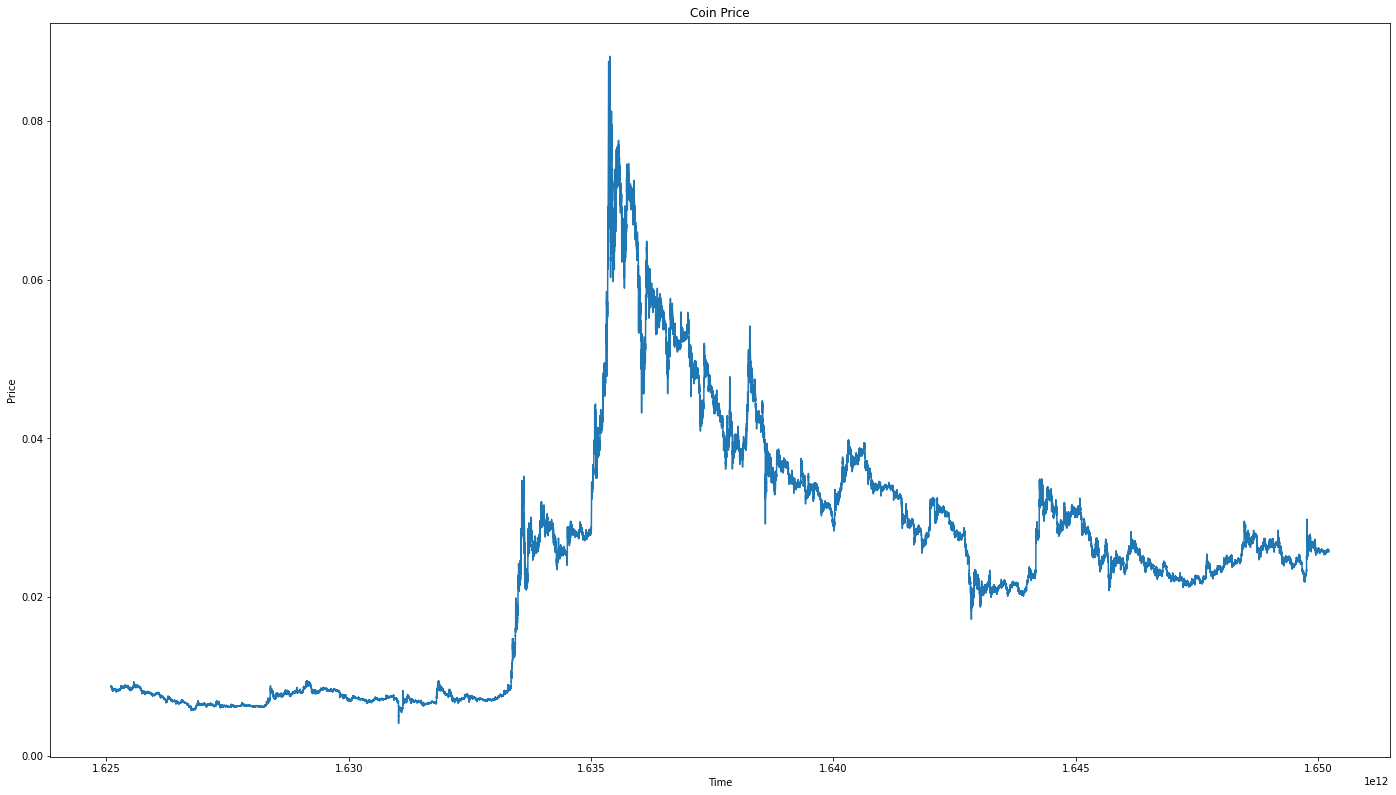

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [22]:
# choose a slice on which to test
wsize_days = 45
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]
len(dataslice)

3888001

In [23]:
hand_tuned = {"config_name": "recursive_grid_1000SHIBUSDT_243days",
 "logging_level": 0,
 "long": {"auto_unstuck_ema_dist": 0.07537071056829926,
          "auto_unstuck_wallet_exposure_threshold": 0.19669988220778298,
          "ddown_factor": 2.977350776264995,
          "ema_span_0": 1590.7673738930807,
          "ema_span_1": 2555.569985614937,
          "enabled": True,
          "initial_eprice_ema_dist": -0.036633754044480854,
          "initial_qty_pct": 0.05183901530921238,
          "markup_range": 0.058494042849077325,
          "min_markup": 0.058764069903290785,
          "n_close_orders": 4,
          "rentry_pprice_dist": 0.03271893972031065,
          "rentry_pprice_dist_wallet_exposure_weighting": 69.40466141303567,
          "wallet_exposure_limit": 0.1632046549148019},
 "short": {"auto_unstuck_ema_dist": 0.09972790931046338,
           "auto_unstuck_wallet_exposure_threshold": 0.06559262162518376,
           "ddown_factor": 2.304489996146624,
           "ema_span_0": 1055.6577441874203,
           "ema_span_1": 2888.7744234017828,
           "enabled": True,
           "initial_eprice_ema_dist": -0.02998678962458838,
           "initial_qty_pct": 0.07702488418844138,
           "markup_range": 0.022206983627948464,
           "min_markup": 0.014231970991650302,
           "n_close_orders": 9,
           "rentry_pprice_dist": 0.01553099174200374,
           "rentry_pprice_dist_wallet_exposure_weighting": 22.60722411105582,
           "wallet_exposure_limit": 0.1517033532129698}}

config_to_test = {**config, **hand_tuned}

In [33]:
df

,price
timestamp,
1625097601000.0,0.008824
1625097602000.0,0.008824
1625097603000.0,0.008824
1625097604000.0,0.008824
1625097605000.0,0.008824
...,...
1650218310000.0,0.025643
1650218311000.0,0.025638
1650218312000.0,0.025623



Grid Span Long = 100.00%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,3280.0,0.025794,long_ientry_normal,3280.0,0.0257940000,0.0084604320,0.0000000000,NaN,0.0
1,9766.0,0.021913,long_rentry,13046.0,0.0228887535,0.0298606678,0.0445285213,2.9774390244,0.0
2,38843.0,0.012629,long_rentry,51889.0,0.0152085206,0.0789154925,0.2042537487,2.9773877050,0.0
4,84397305.0,0.000001,long_ientry_partial,84603686.0,0.0000066932,0.0566267642,5.6931793255,408.9393161192,0.0
3,154492.0,-0.001989,long_rentry,206381.0,0.0023348580,0.0481870337,-2.1738853893,2.9773555089,0.0


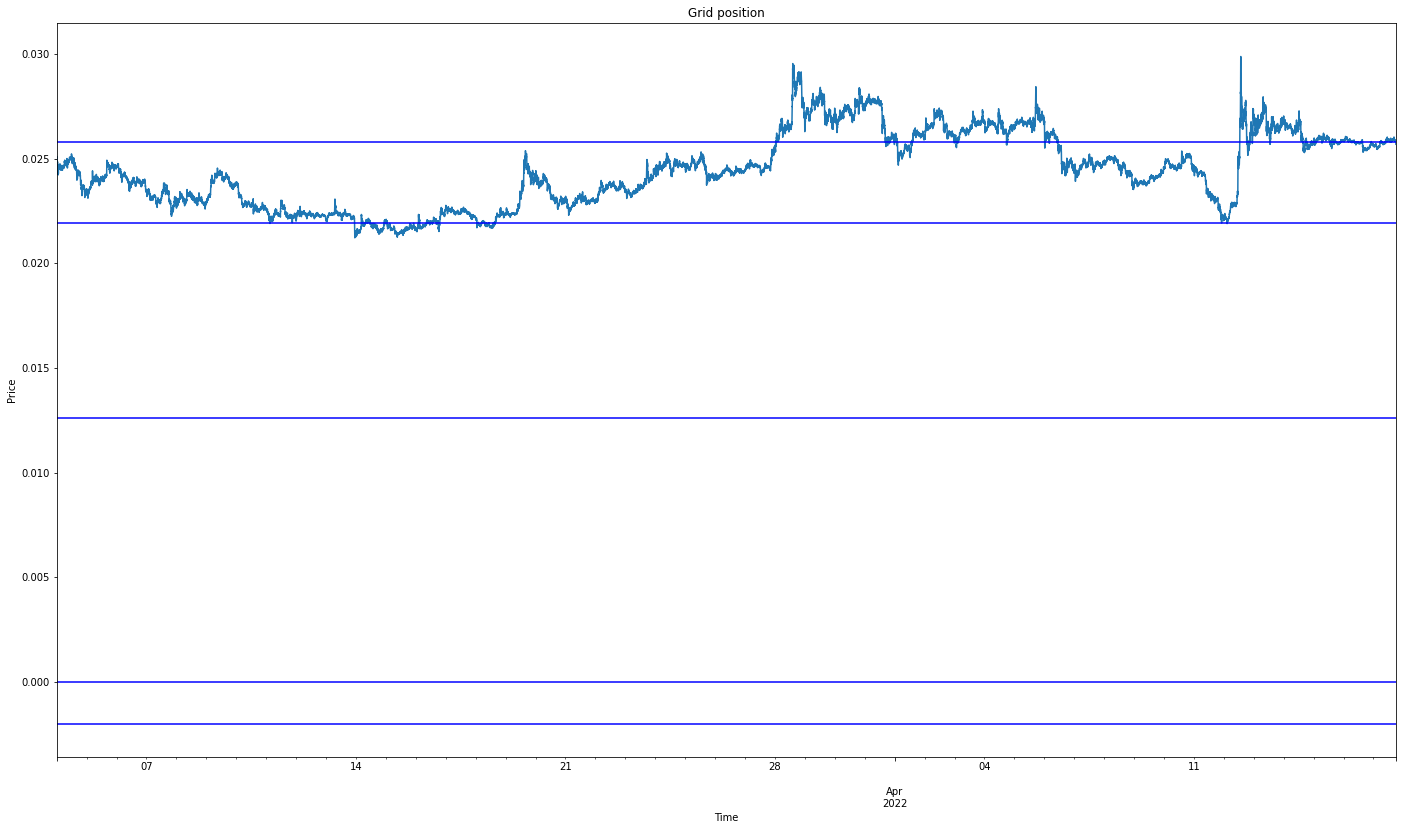

In [28]:
config_to_test['long'] = {"auto_unstuck_ema_dist": 0.07537071056829926,
          "auto_unstuck_wallet_exposure_threshold": 0.19669988220778298,
          "ddown_factor": 2.977350776264995,
          "ema_span_0": 1590.7673738930807,
          "ema_span_1": 2555.569985614937,
          "enabled": True,
          "initial_eprice_ema_dist": -0.036633754044480854,
          "initial_qty_pct": 0.05183901530921238,
          "markup_range": 0.058494042849077325,
          "min_markup": 0.058764069903290785,
          "n_close_orders": 4,
          "rentry_pprice_dist": 0.03271893972031065,
          "rentry_pprice_dist_wallet_exposure_weighting": 69.40466141303567,
          "wallet_exposure_limit": 0.1632046549148019}

start_from = -100



grid_long = calc_recursive_entries_long(
    Args().starting_balance, # balance
    0.0, # psize
    0.0, # pprice
    df.price.iloc[-1], # highest_bid
    df.price.iloc[-1], # ema_band_lower
    config_to_test["inverse"], # inverse
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 45  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=45) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf_long.itertuples()):
    fig.axhline(y=e.price, color="b", linestyle="-")

print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long]).sort_values("price", ascending=False)

Grid Span Short = 23.20%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
2,-34717.0,0.031574,short_rentry,-49782.0,0.0301457251,0.1500714485,0.0452357933,2.3044805841,0.2310215436
1,-10506.0,0.027386,short_rentry,-15065.0,0.0268542932,0.0404559927,0.0194152780,2.3044527309,0.6906445355
0,3301.0,0.025629,long_ientry_normal,3301.0,0.0256290000,0.0084601329,0.0000000000,NaN,0.0000000000
0,-4559.0,0.025629,short_ientry_normal,-4559.0,0.0256290000,0.0116842611,0.0000000000,NaN,2.2190924788
1,9828.0,0.023861,long_rentry,13129.0,0.0243055249,0.0319107237,0.0186297701,2.9772796122,0.0000000000
2,39090.0,0.018993,long_rentry,52219.0,0.0203286851,0.1061543607,0.0703251248,2.9773783228,0.0000000000
3,91164.0,0.006258,long_rentry,143383.0,0.0113824367,0.1632047919,0.8188617264,1.7458013367,0.0000000000


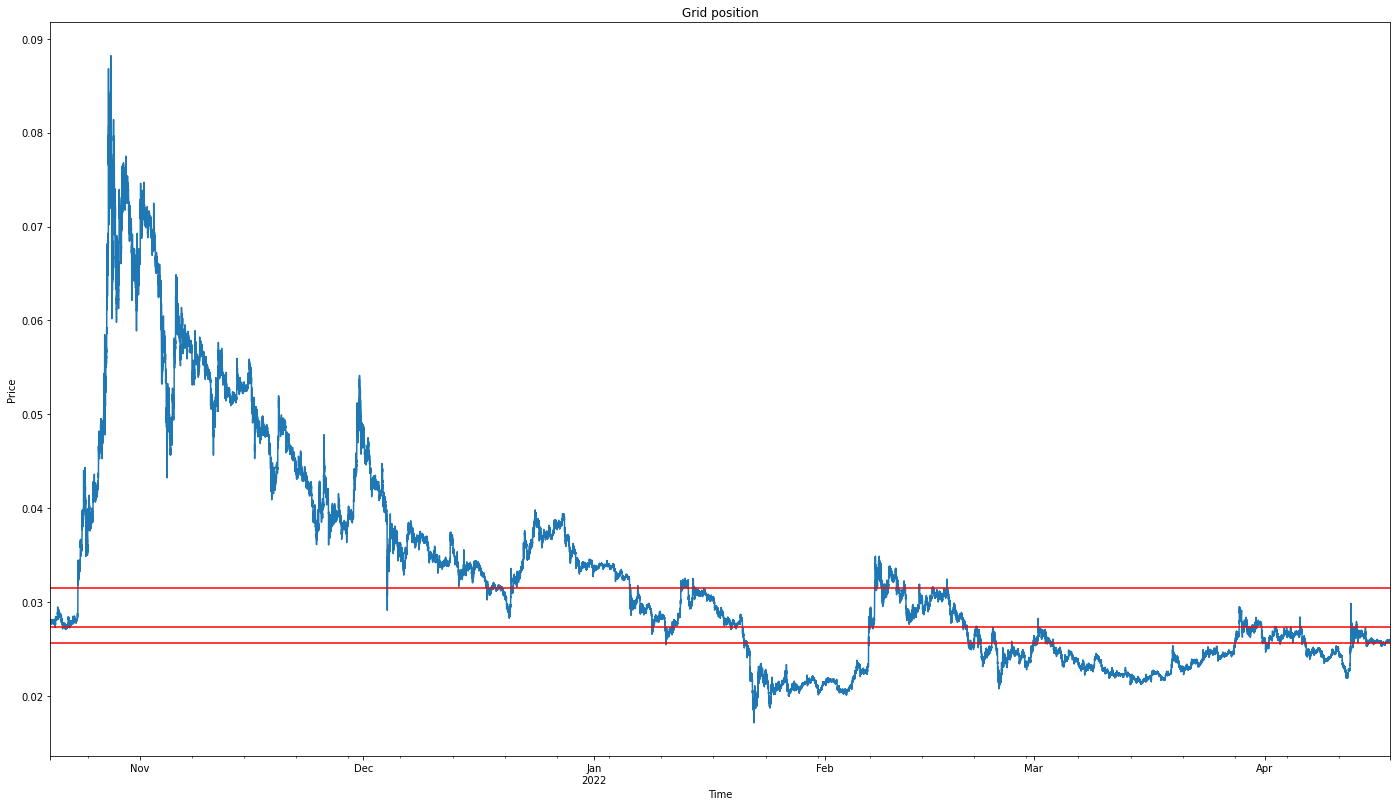

In [9]:
############ SHORT ####################
config_to_test['short'] = {"auto_unstuck_ema_dist": 0.09972790931046338,
           "auto_unstuck_wallet_exposure_threshold": 0.06559262162518376,
           "ddown_factor": 2.304489996146624,
           "ema_span_0": 1055.6577441874203,
           "ema_span_1": 2888.7744234017828,
           "enabled": True,
           "initial_eprice_ema_dist": -0.02998678962458838,
           "initial_qty_pct": 0.07702488418844138,
           "markup_range": 0.022206983627948464,
           "min_markup": 0.014231970991650302,
           "n_close_orders": 9,
           "rentry_pprice_dist": 0.025,
           "rentry_pprice_dist_wallet_exposure_weighting": 22.60722411105582,
           "wallet_exposure_limit": 0.1517033532129698}

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 180  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)

for i, e in enumerate(gdf_short.itertuples()):
    fig.axhline(y=e.price, color="r", linestyle="-")
print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

In [10]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 17.6159
{'DGstd_long': 0.001917474958793573,
 'DGstd_short': 0.001845264534726066,
 'adg_DGstd_ratio_long': 0.14383590804699403,
 'adg_DGstd_ratio_short': 0.16928491699927256,
 'adg_long': 0.000275801751855446,
 'adg_per_exposure_long': 0.0016899135137991219,
 'adg_per_exposure_short': 0.0020591202962025033,
 'adg_realized_long': 0.00027841647526627433,
 'adg_realized_per_exposure_long': 0.001705934646359301,
 'adg_realized_per_exposure_short': 0.002051291730822913,
 'adg_realized_short': 0.0003111878339838725,
 'adg_short': 0.00031237545360280337,
 'avg_fills_per_day_long': 1.7333333333333334,
 'avg_fills_per_day_short': 10.366666666666667,
 'biggest_psize_long': 46018.0,
 'biggest_psize_quote_long': 1061.588567,
 'biggest_psize_quote_short': 1544.2066929999999,
 'biggest_psize_short': 60627.0,
 'closest_bkr_long': 1.0,
 'closest_bkr_short': 1.0,
 'eqbal_ratio_mean_long': 0.9984732184029229,
 'eqbal_ratio_mean_short': 0.9985740802639563,
 'eqbal_ratio_min_long': 0.9896

In [11]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1645034314000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.030226,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.000000000,0.0000000000,0.0000000000
1,1645034374000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.030268,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.000000000,0.0000000000,0.0000000000
2,1645034434000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.030258,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.000000000,0.0000000000,0.0000000000
3,1645034494000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.030260,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.000000000,0.0000000000,0.0000000000
4,1645034554000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.030281,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86396,1650218074000.0,0.0,2.1873396786,3252.0,0.026457,-4713.0,0.0255664792,0.025798,1.0,1.0,10168.4293282814,10188.4370886595,10166.2862602814,10187.345931361,0.0084613032,0.0118266242
86397,1650218134000.0,0.0,2.1873396786,3252.0,0.026457,-4713.0,0.0255664792,0.025797,1.0,1.0,10168.4293282814,10188.4370886595,10166.2830082814,10187.350644361,0.0084613032,0.0118266242
86398,1650218194000.0,0.0,2.1873396786,3252.0,0.026457,-4713.0,0.0255664792,0.025796,1.0,1.0,10168.4293282814,10188.4370886595,10166.2797562814,10187.355357361,0.0084613032,0.0118266242
86399,1650218254000.0,0.0,2.1873396786,3252.0,0.026457,-4713.0,0.0255664792,0.025752,1.0,1.0,10168.4293282814,10188.4370886595,10166.1366682814,10187.562729361,0.0084613032,0.0118266242


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

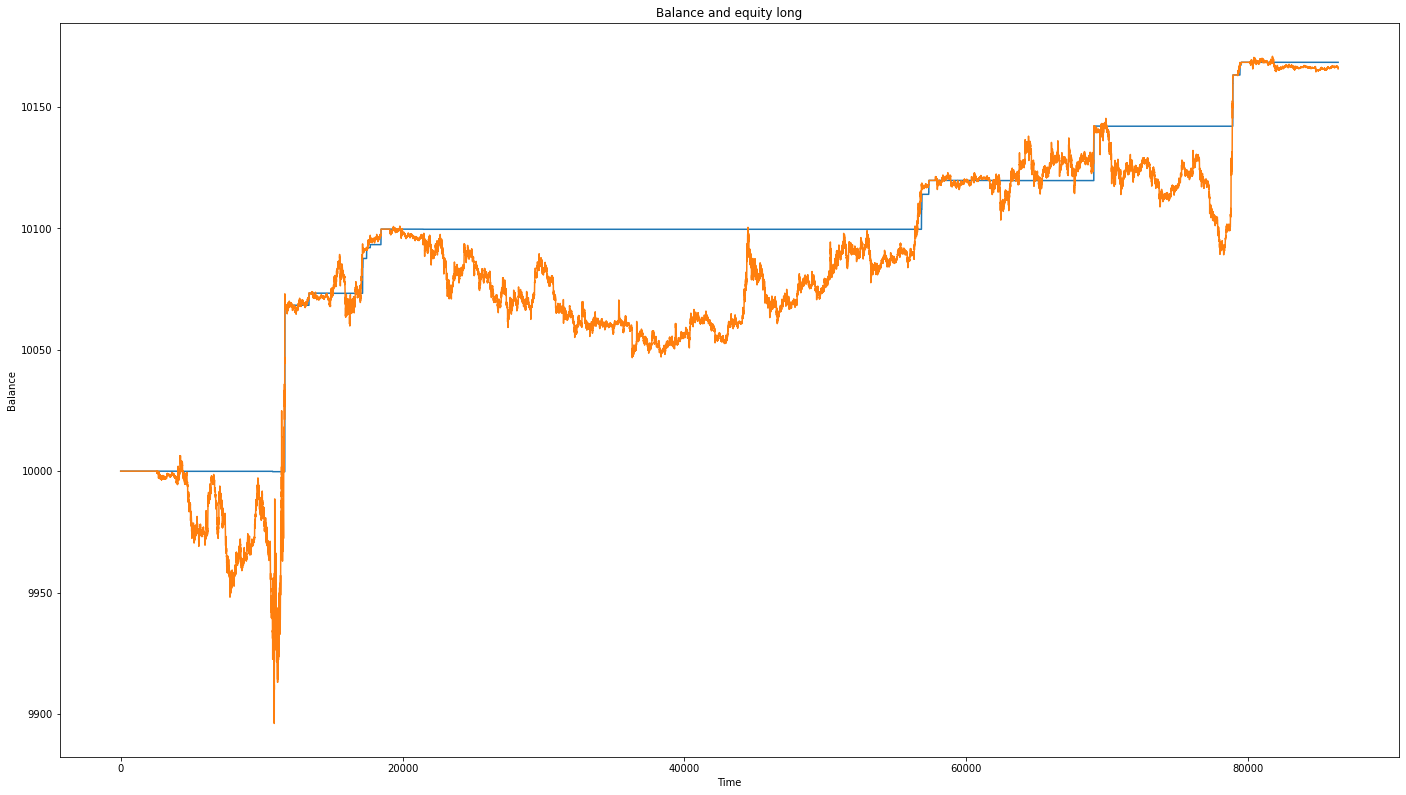

In [12]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

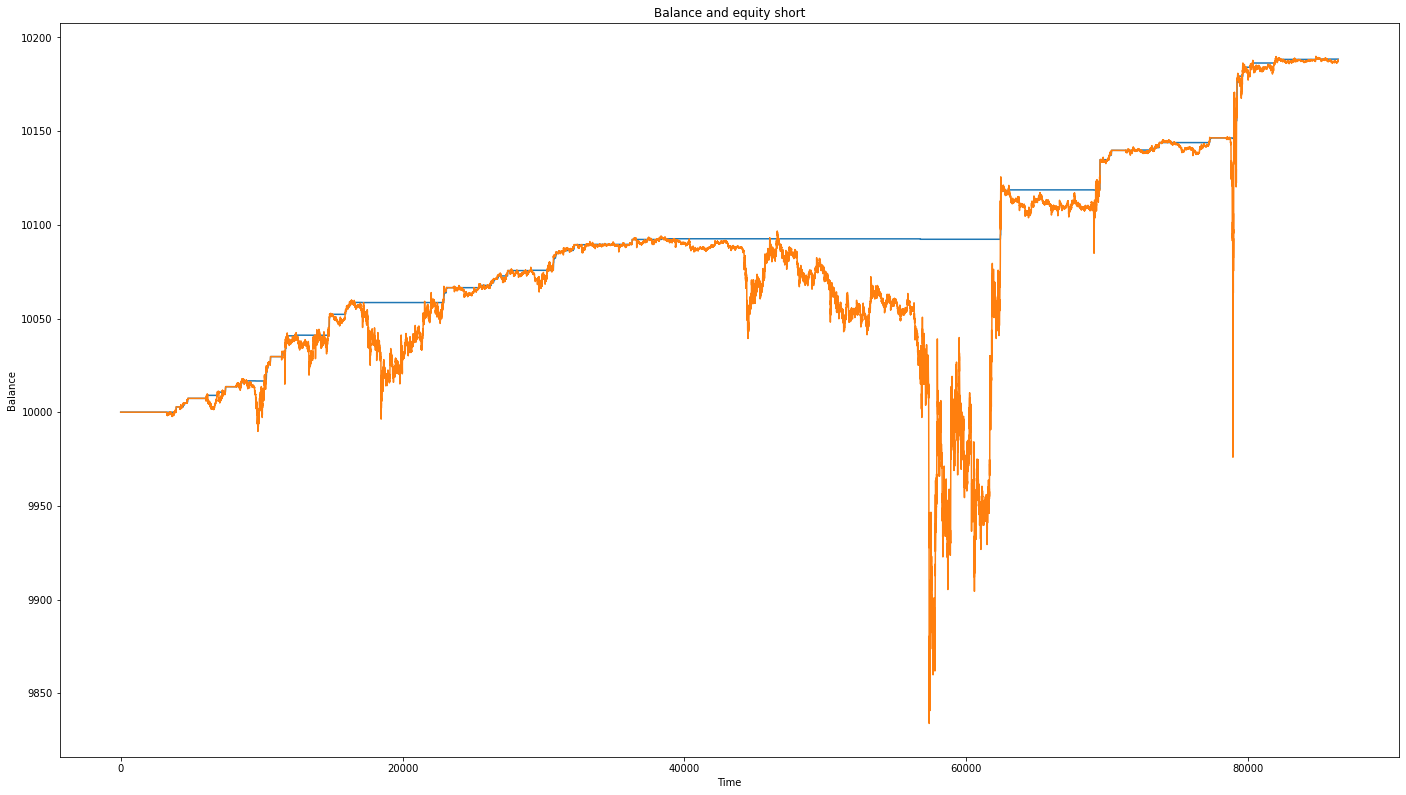

In [13]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

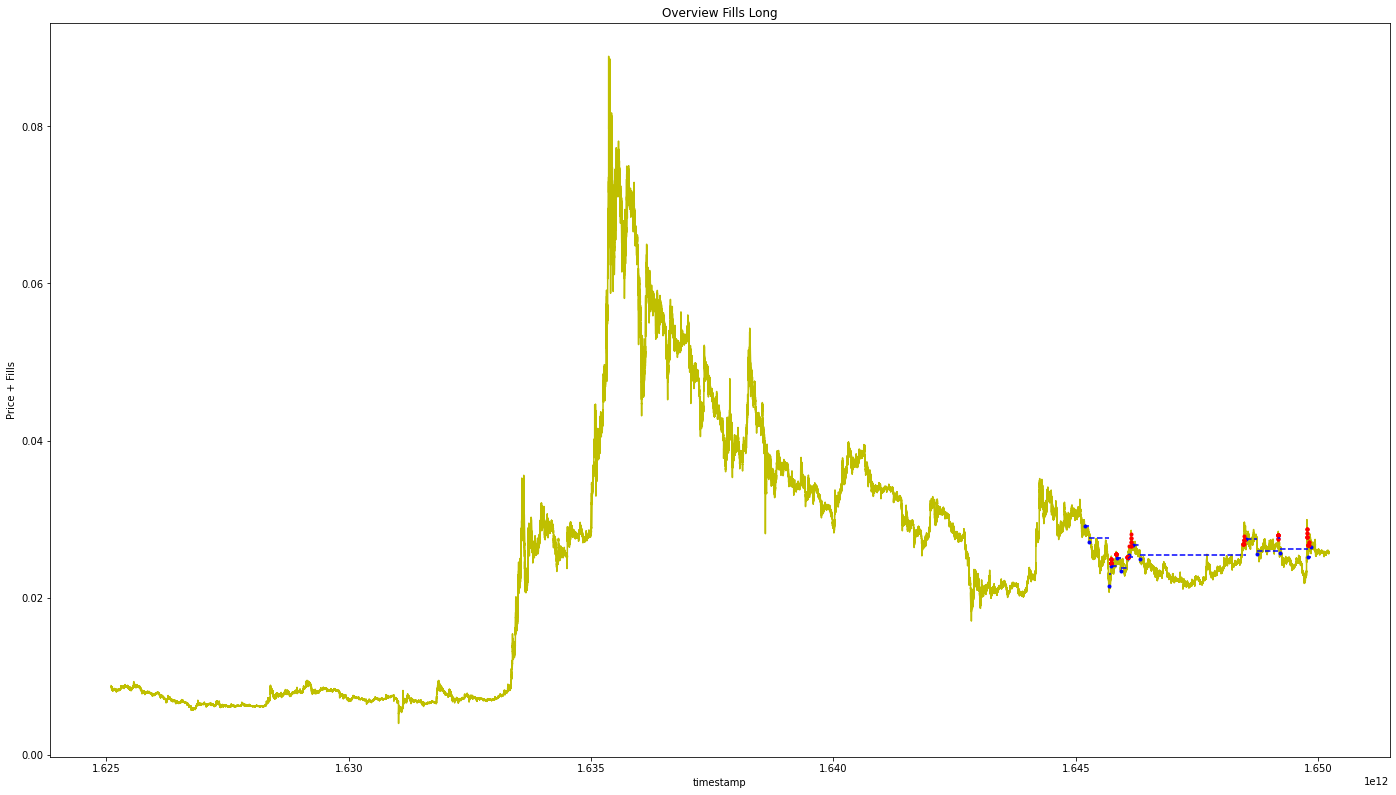

In [14]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

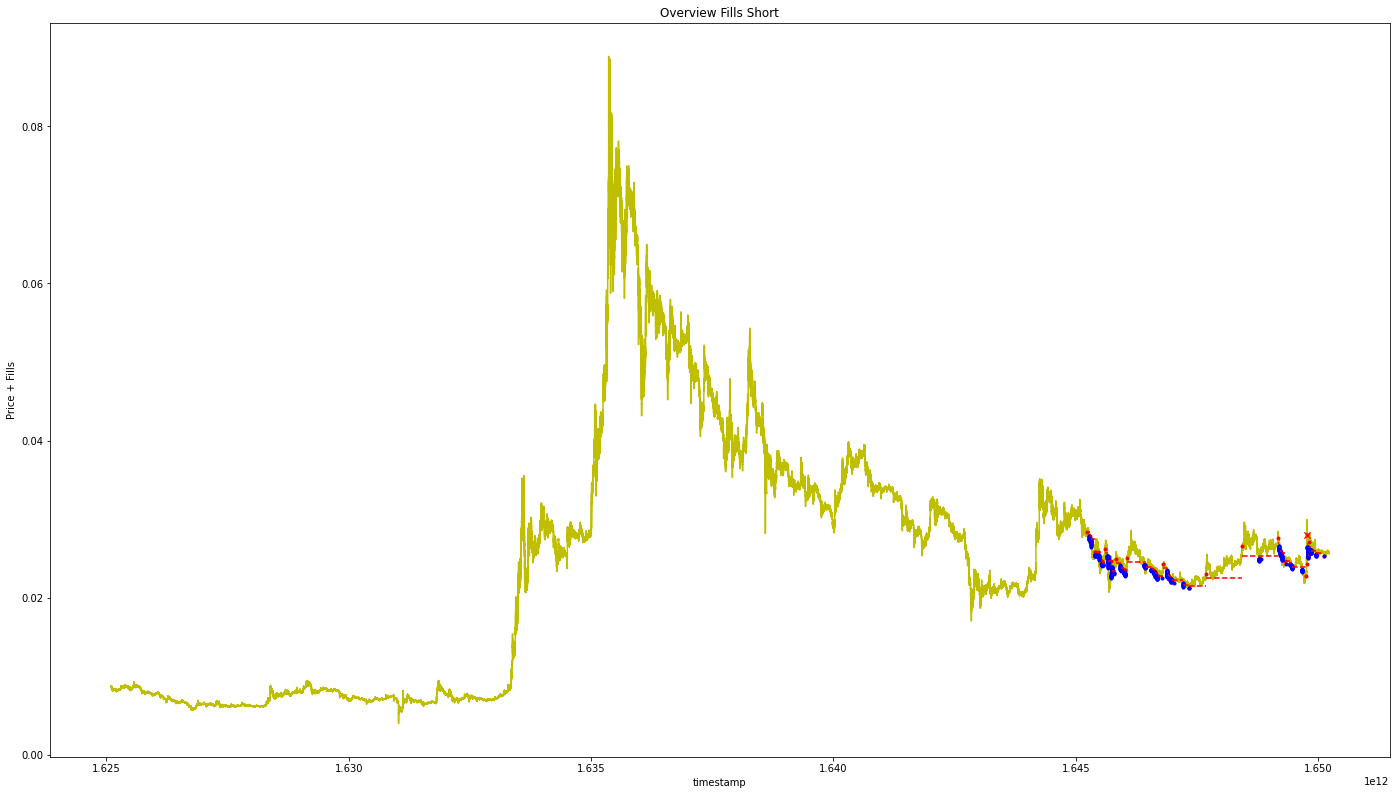

In [15]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

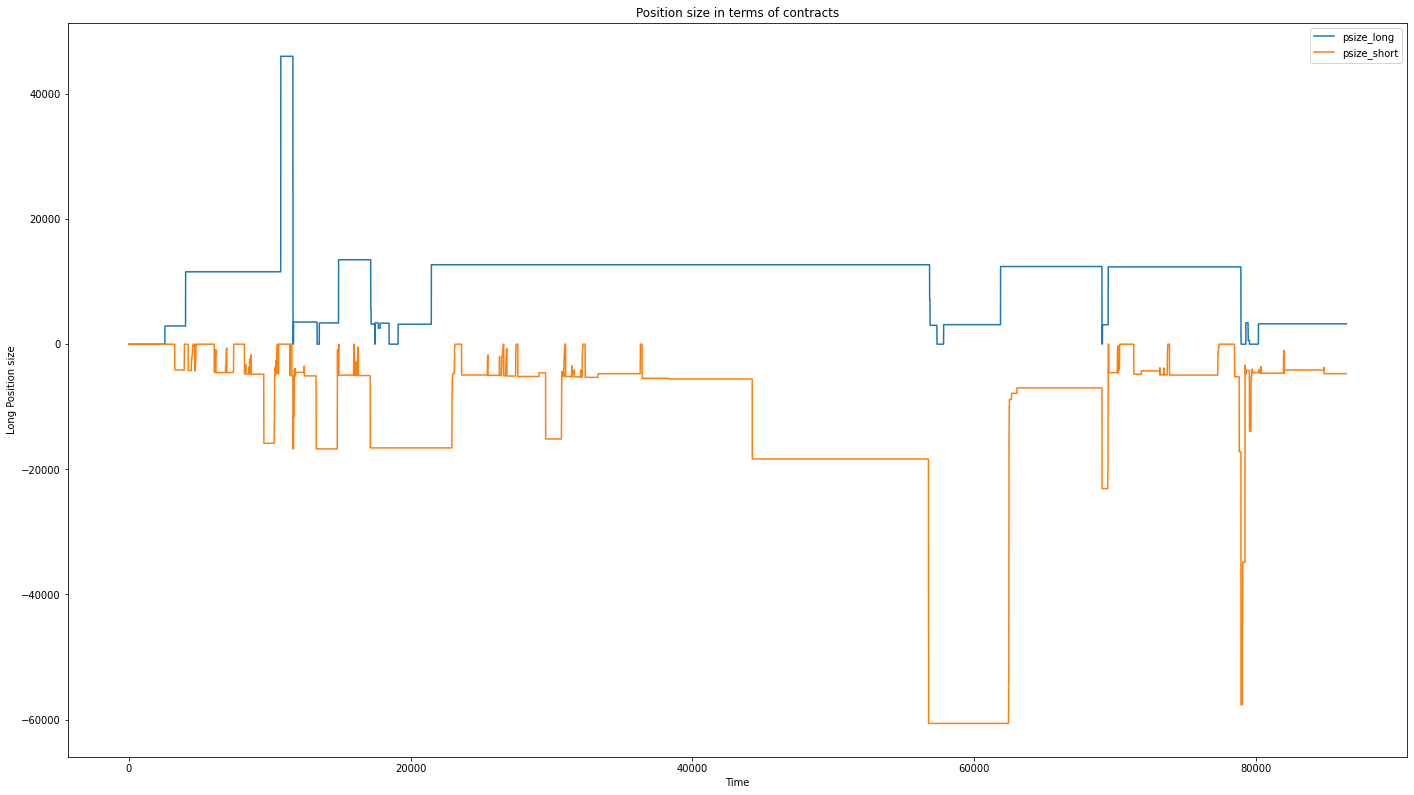

In [16]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

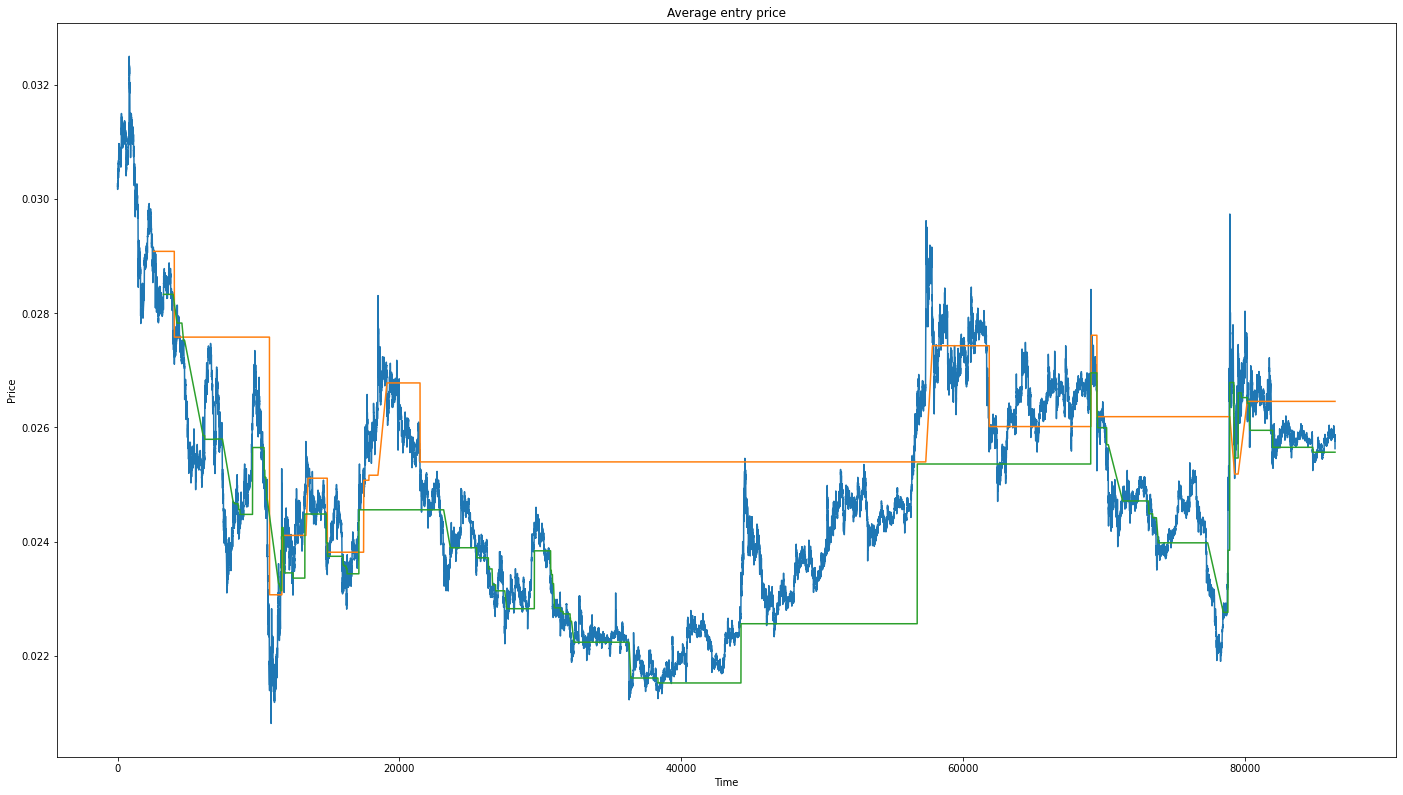

In [17]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()

Price action distance long mean 0.063617 std 0.050842


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

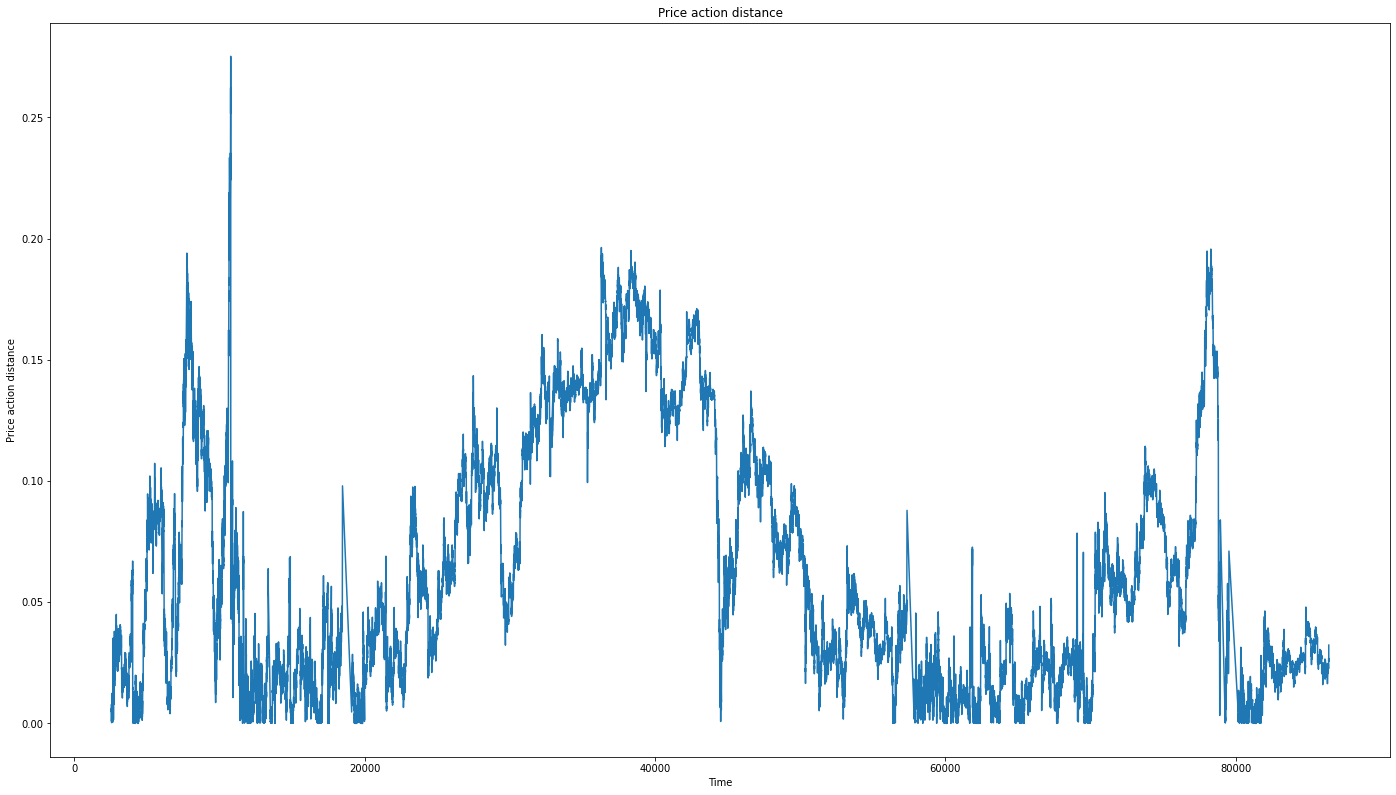

In [18]:
lpprices = sdf[sdf.psize_long != 0.0]
PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Price action distance long mean {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
PADistance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.030834


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

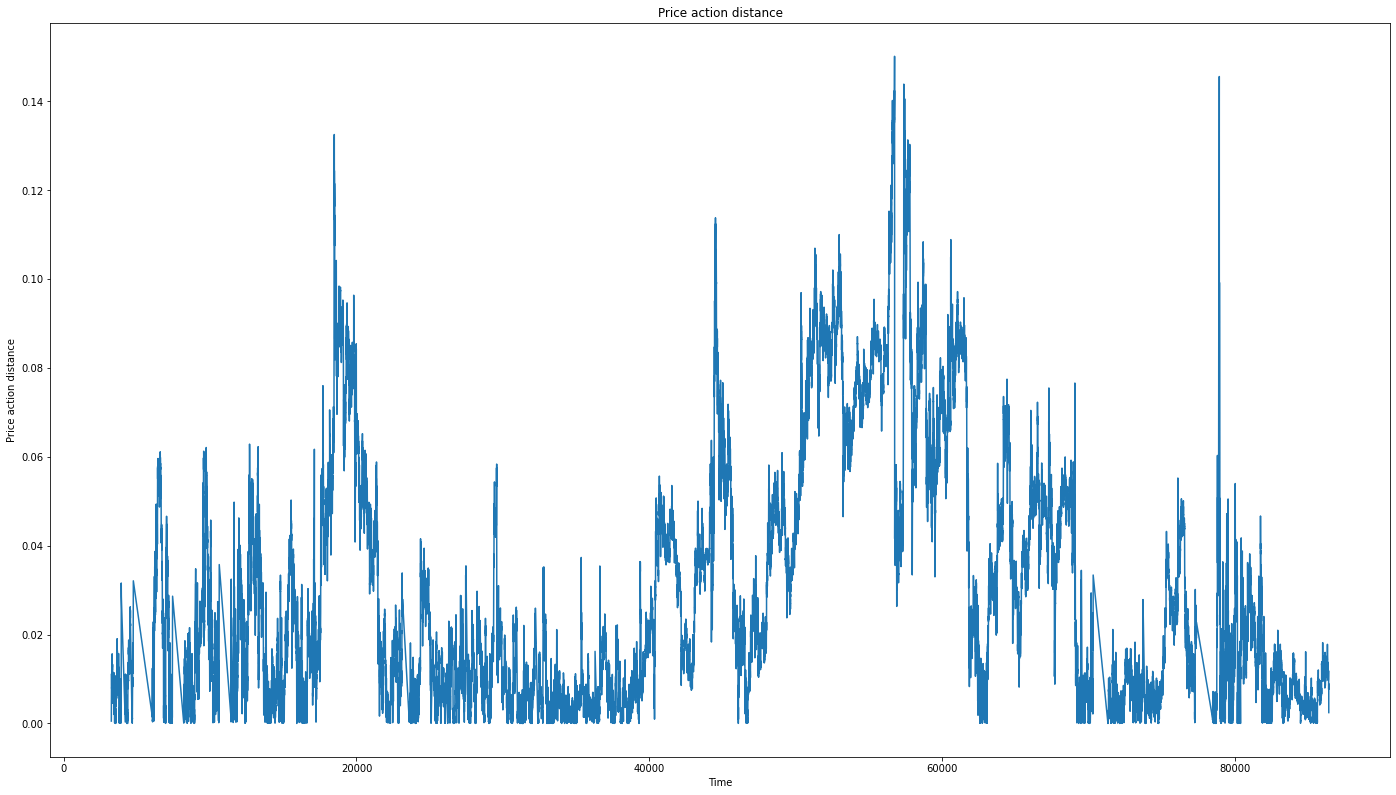

In [19]:
spprices = sdf[sdf.psize_short != 0.0]
PADistance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {PADistance_short.mean():.6f}")
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [1590.7673738930807, 2016.263215658276, 2555.569985614937] n_days 290.7


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

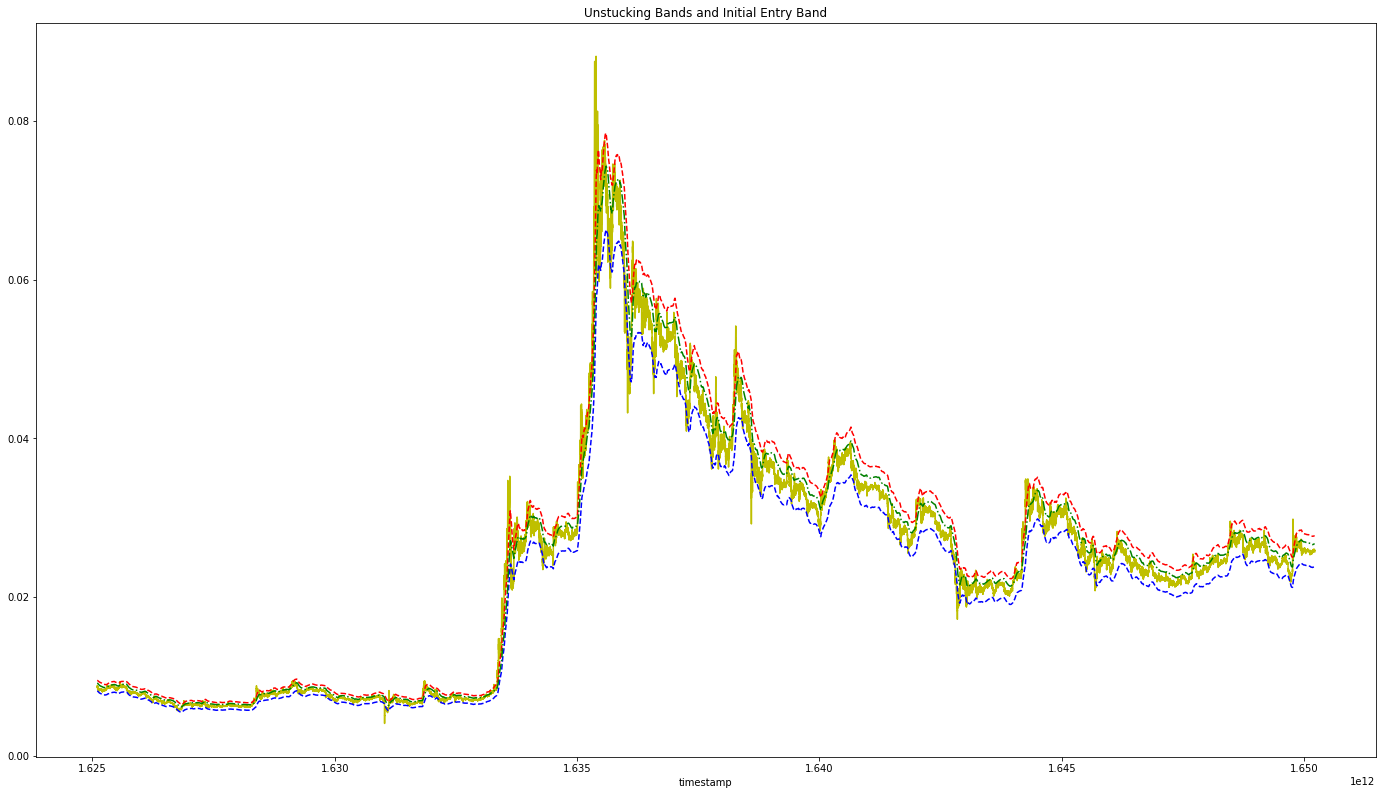

In [20]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [1055.6577441874203, 1746.298110654261, 2888.7744234017828] n_days 290.7


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

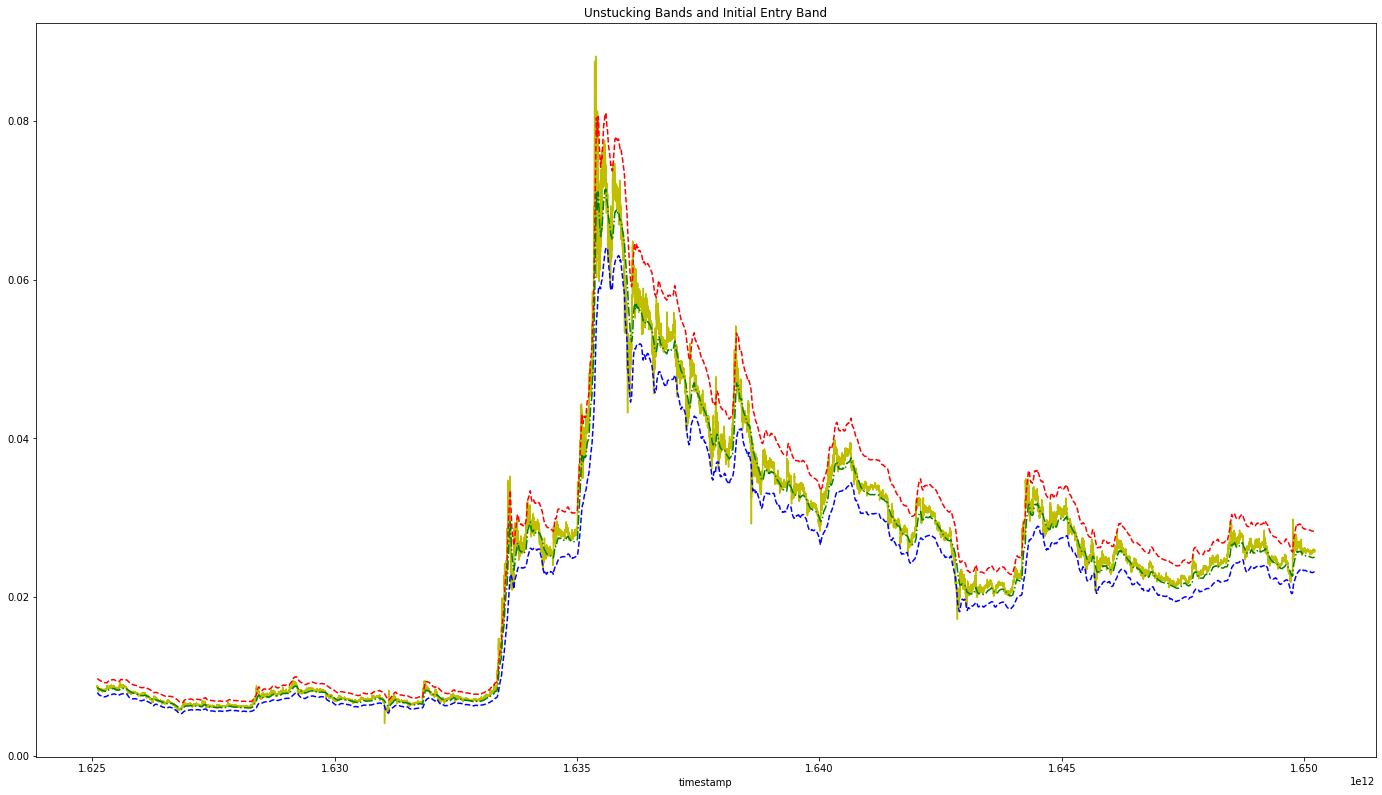

In [21]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")